## Setup

In [1]:
import os
import pathlib
import warnings

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    estimate_sigma,
)
from skimage import data
from skimage.util import random_noise

from utils import plot_batch

warnings.simplefilter("ignore")

Tensorflow's dominance over numpy is usage of tensors, which (in short) allows to dirstibute computation to gpu, which is better suited for muliplying large matrices, therefore leads to faster computation and allows to deal with more data at once.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [3]:
DATA_DIR = os.path.join(os.path.abspath(os.curdir), "data")
os.makedirs(DATA_DIR, exist_ok=True)

## Downloading data

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

archive = tf.keras.utils.get_file(origin=dataset_url, extract=True, cache_dir=DATA_DIR)
data_dir = pathlib.Path(archive).with_suffix("")

## Creating dataset

In [5]:
batch_size = 32
img_height = 180
img_width = 180
seed = 42

In [6]:
def get_ds(data_dir: pathlib.Path, subset: str) -> tf.data.Dataset:
    return tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset=subset,
        seed=seed,
        # image_size=(img_height, img_width),
        batch_size=batch_size,
    )


train_ds = get_ds(data_dir, "training")
val_ds = get_ds(data_dir, "validation")

class_names = train_ds.class_names
print("\nClasses: " + ", ".join(class_names))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-11-02 12:47:08.499558: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-02 12:47:08.499605: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-02 12:47:08.499628: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-02 12:47:08.499696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-02 12:47:08.499730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.

Classes: daisy, dandelion, roses, sunflowers, tulips


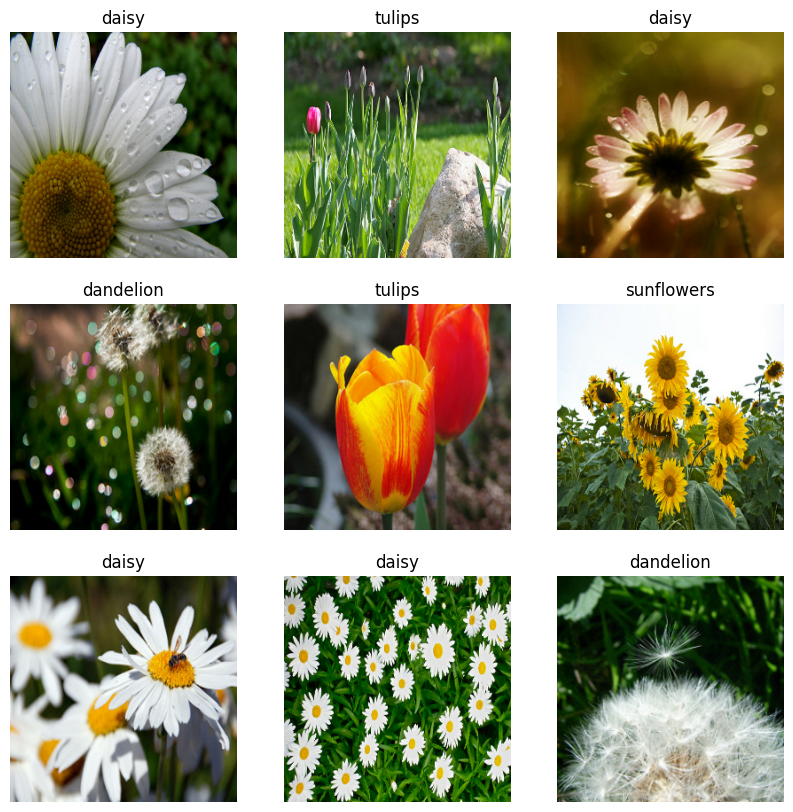

In [7]:
# rebatch - overwrites batch size
# take - take one batch - in below case it will return Tensor of shape [9, img_height, img_width, 3]
# 3 stands for rgb format

for x, y in train_ds.rebatch(9).take(1):
    plot_batch(x, labels=y, class_names=class_names, ncols=3)

## Image resizing and rescalling

Probably most commonly used operations on images are rescaling their pixel values to range <0, 1> (that's because most of models achiche better scores on these type of data distribution) and photo resizing - working with high resolution images is extremely expensive, for most usecases downcasting them to lower resolution will preserve enough information to produce acceptable results.

In [8]:
img, label = train_ds.rebatch(1).take(1).__iter__().__next__()
img.shape

TensorShape([1, 256, 256, 3])

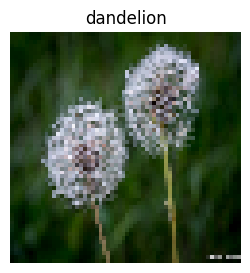

In [9]:
def nearest(img: np.ndarray, width: int, height: int) -> np.ndarray:
    s = np.array([height / img.shape[0], width / img.shape[1]])
    r = np.empty([height, width, img.shape[2]], dtype=img.dtype)

    for i in range(height):
        for j in range(width):
            r[i, j] = img[int(i / s[0]), int(j / s[1])]
    return r


resized_img = nearest(img[0].numpy(), 60, 60)
plot_batch(
    resized_img[np.newaxis, :, :, :],
    labels=label,
    class_names=class_names,
    figsize=(3, 3),
)

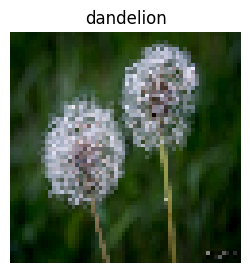

In [10]:
resized_img_tensorflow = layers.Resizing(60, 60, "nearest")(img)
plot_batch(
    resized_img_tensorflow, labels=label, class_names=class_names, figsize=(3, 3)
)

In [11]:
# mean pixel difference between our and tensorflow implementation
np.mean(np.abs(resized_img - resized_img_tensorflow.numpy()[0]))

14.681442

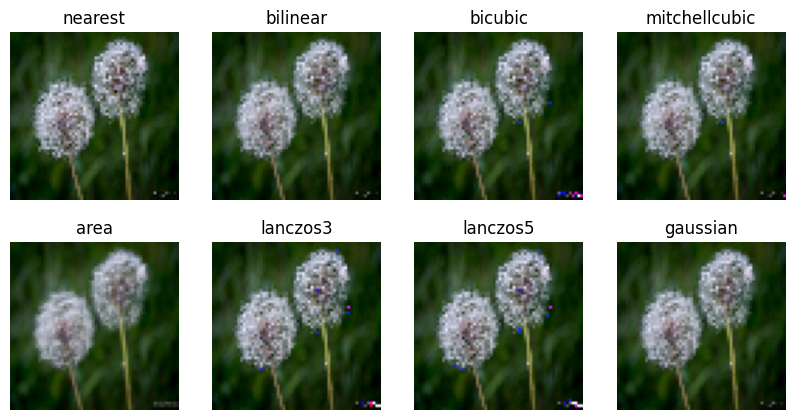

In [12]:
def deomnostrate_interpolation(names):
    resized_imgs_tensorflow = [
        layers.Resizing(60, 60, name)(img)[0].numpy() for name in names
    ]
    plot_batch(np.stack(resized_imgs_tensorflow), names=names, figsize=(10, 5), ncols=4)


# https://www.tensorflow.org/api_docs/python/tf/image/resize
# https://pixinsight.com/doc/docs/InterpolationAlgorithms/InterpolationAlgorithms.html
deomnostrate_interpolation(
    [
        # O(n*m)
        # good to use for real-time interpolation thus it's fastest
        "nearest",
        # https://theailearner.com/2018/12/29/image-processing-nearest-neighbour-interpolation/
        # O(4 * n*m)
        # default, takes into consideration 2x2 nearest neighbours and resulting pixel will
        # be weighted mean of their values, where weight is defined by distance to the pixel
        # results in smoother image than nearest,
        "bilinear",
        # https://theailearner.com/2018/12/29/image-processing-bilinear-interpolation/
        # https://en.wikipedia.org/wiki/Bilinear_interpolation
        # O(16 * n*m)
        # takes into consideration 4x4 nearest neighbours (note: this requires padding).
        # Prodices sharper images, but may cause cropping (which is not nessesarly bad)
        # good to use when dealing with photographs / images of natural scenes
        "bicubic",
        # https://theailearner.com/2018/12/29/image-processing-bicubic-interpolation/
        # https://en.wikipedia.org/wiki/Bicubic_interpolation
        # ~O(n*m^2)
        # takes into consideration 4x4 nearest neighbours, maintain better balance between
        # sharpness and bluriness, here B=C=1/3
        # good when we want natural-looking details
        "mitchellcubic",
        # https://en.wikipedia.org/wiki/Mitchell–Netravali_filters
        # O(n * m) - O(n^2 * m^2) - it depends on how many pixels we take into consideration
        # only for downcasting, usually fast - depends on how many pixels we consider at once
        # produces rather pixelised, low quality images
        # good for signiphicant downscalling, bad for upscalling
        "area",
        # O(n * m * 4 * a^2)
        # produces most charp images
        # good to use with images with sharp edges / text / fine textures
        "lanczos3",
        "lanczos5",
        # https://en.wikipedia.org/wiki/Lanczos_resampling
        # https://mazzo.li/posts/lanczos.html
        "gaussian"
        # https://en.wikipedia.org/wiki/Normal_distribution
        # good to use when we expect rater artiscic effect, without sharp edges
    ]
)

Final shape - (180, 180, 3), (min, max) pixel values - (0.0, 0.98812336)


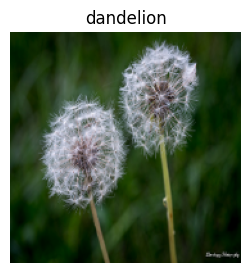

In [13]:
resize_and_rescale = keras.Sequential(
    [
        layers.Resizing(img_height, img_width, crop_to_aspect_ratio=False),
        layers.Rescaling(1.0 / 255),
    ]
)

processed_img = resize_and_rescale(img)
plot_batch(
    processed_img, labels=label, class_names=class_names, figsize=(3, 3), float_=True
)
print(
    f"Final shape - {processed_img[0].shape}, (min, max) pixel values - {np.min(processed_img), np.max(processed_img)}"
)

## Image filtering

Covered in different [notebook](./filtering.ipynb)

## Data augumentation

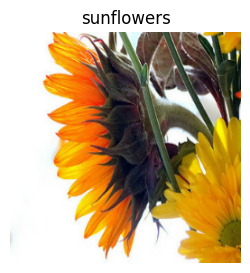

In [12]:
# here are some more advanced image operations

x, y = train_ds.rebatch(1).take(1).__iter__().next()
x_numpy = x.numpy()[0, :, :, :]
plot_numpy = lambda x, **kw: plot(x[np.newaxis, ...], y, figsize=(3, 3), **kw)
plot_numpy(x_numpy)

(256, 256)


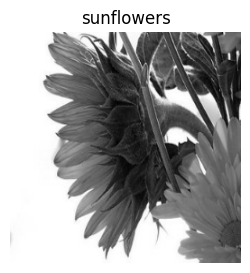

In [13]:
# grayscale
x_new = cv2.cvtColor(x_numpy, cv2.COLOR_BGR2GRAY)
plot_numpy(x_new, cmap="gray")
print(x_new.shape)  # now it has just one channel

100.0
[  0. 255.]


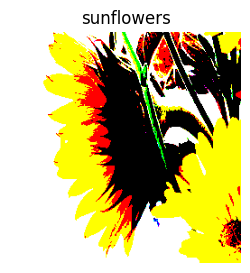

In [14]:
# map all pixels greater than thresshold to 255, rest to 0 on each channel
ret, x_new = cv2.threshold(x_numpy, 100, 255, cv2.THRESH_BINARY)
print(ret)  # used threshold
print(np.unique(x_new))  # just 0 and 255
plot_numpy(x_new)

## Denoising

In [15]:
def add_gaussian_noise(image, mean=0, std=10):
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = cv2.add(image, noise)
    return noisy_image


x_numpy_noise = add_gaussian_noise(x_numpy)

In [43]:
denoise = lambda img: [
    img,
    denoise_tv_chambolle(img, weight=0.4, channel_axis=-1),
    denoise_tv_chambolle(img, weight=0.8, channel_axis=-1),
    denoise_bilateral(img, sigma_color=0.2, sigma_spatial=15, channel_axis=-1),
    denoise_bilateral(img, sigma_color=0.4, sigma_spatial=30, channel_axis=-1),
    denoise_wavelet(img, channel_axis=-1, rescale_sigma=True),
    denoise_wavelet(img, channel_axis=-1, convert2ycbcr=True, rescale_sigma=True),
    cv2.fastNlMeansDenoisingColored(
        img.astype(np.uint8), h=20, hColor=30, templateWindowSize=7, searchWindowSize=21
    ),
]
labels = [
    "noise",
    "tv_chambolle",
    "tv_chambolle stronger",
    "bilateral",
    "bilateral stronger",
    "wavelet",
    "wavelet (YCbCr colorspace)",
    "fastNlMeans",
]

In [41]:
def plot_denoisers(noise_img):
    plt.figure(figsize=(10, 5))
    for i, (img, label) in enumerate(zip(denoise(noise_img), labels)):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img.astype("uint8"))
        plt.axis("off")
        plt.title(label)

        sigma_est = estimate_sigma(img, channel_axis=-1, average_sigmas=True)
        print(
            f"Estimated Gaussian noise standard deviation for '{label}' = {sigma_est}"
        )
    plt.show()

In [45]:
plot_denoisers(x_numpy_noise)

KeyboardInterrupt: 

<Figure size 1000x500 with 0 Axes>

Estimated Gaussian noise standard deviation for 'noise' = 38.11168158898395
Estimated Gaussian noise standard deviation for 'tv_chambolle' = 36.81681453071179
Estimated Gaussian noise standard deviation for 'tv_chambolle stronger' = 35.564006686018764
Estimated Gaussian noise standard deviation for 'bilateral' = 38.106683053212784
Estimated Gaussian noise standard deviation for 'bilateral stronger' = 38.12847509165671
Estimated Gaussian noise standard deviation for 'wavelet' = 1.5707091905375742e-15
Estimated Gaussian noise standard deviation for 'wavelet (YCbCr colorspace)' = 8.23129506735703e-15
Estimated Gaussian noise standard deviation for 'fastNlMeans' = 3.20919586405781


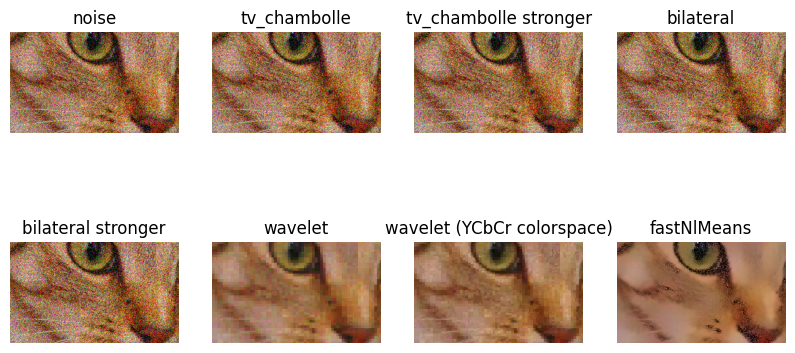

In [49]:
original = data.chelsea()[100:250, 50:300]
noisy = random_noise(original, var=0.155**2)
plot_denoisers(noisy)

In [54]:
def create_rotation_movie(img):
    fractions = np.linspace(0, 0.1, 30)
    return [
        layers.RandomRotation(
            (f, f), fill_mode="reflect", interpolation="bilinear", seed=seed
        )(img)
        .numpy()
        .astype("uint8")
        for f in fractions
    ]


noisy_images = create_rotation_movie(x_numpy_noise)

In [55]:
from matplotlib import animation
from IPython.display import display, HTML


def plot_movie(imgs, fps=30, figsize=(2, 2), **kw):
    fig = plt.figure(figsize=figsize)

    def animate(i):
        plt.imshow(noisy_images[i].astype("uint8"))
        plt.axis("off")

    anim = animation.FuncAnimation(
        fig,
        animate,
        frames=len(imgs),
        interval=1000.0 / fps,
        repeat_delay=1000,
        repeat=True,
    )
    display(HTML(anim.to_html5_video()))
    plt.close()


plot_movie(noisy_images)

Estimated Gaussian noise standard deviation = 1.6408809905789978


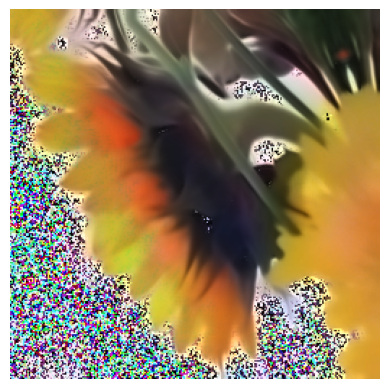

In [63]:
denoised = cv2.fastNlMeansDenoisingColoredMulti(
    noisy_images,
    imgToDenoiseIndex=15,
    temporalWindowSize=9,
    h=20,
    hColor=30,
    templateWindowSize=7,
    searchWindowSize=21,
)
sigma_est = estimate_sigma(denoised, channel_axis=-1, average_sigmas=True)
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

plt.imshow(denoised.astype("uint8"))
plt.axis("off")
plt.show()

## dataset interface for performance boost